In [5]:
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn

mms = MinMaxScaler()
pca = PCA(n_components=2)

mnist = fetch_openml('mnist_784')
X_orig, y_orig = mnist["data"], mnist["target"]

X_orig = mms.fit_transform(np.array(X_orig).astype(np.float32))
y_orig = np.array(y_orig).astype(np.uint8)
target_digit1 = 3
target_digit2 = 8

target_digit1_xdata = X_orig[y_orig == target_digit1]
target_digit2_xdata = X_orig[y_orig == target_digit2]
target_digit1_ydata = y_orig[y_orig == target_digit1]
target_digit2_ydata = y_orig[y_orig == target_digit2]
X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)

y = np.where(y == target_digit1, -1, 1)

# reduce the dimensions of X
# X = pca.fit_transform(X)
# scale to 0/1
X = mms.fit_transform(X)

# add on the bias
X = np.concatenate([np.ones_like(X[:, :1]), X],axis=-1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# pca.fit(X_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(8379, 785) (2793, 785) (2794, 785)
(8379,) (2793,) (2794,)


In [7]:
X_train = X_train
y_train = y_train

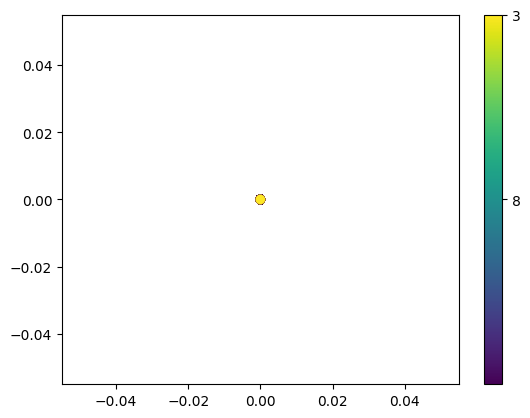

In [8]:
# pca2 = PCA(n_components=2)
# plotx = pca.fit_transform(X_train)

formatter = plt.FuncFormatter(lambda i, *args: np.where(y_train[i] == 1, target_digit2, target_digit1))
plt.scatter(X_train[:, 1], X_train[:, 2], c=y_train)
plt.colorbar(ticks=[0, 1], format=formatter)
# plt.xlabel(iris.feature_names[x_index])
# plt.ylabel(iris.feature_names[y_index])
plt.show()

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
device = 'cpu'
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).to(device)
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=1024)
test_dl = TensorDataset(X_test, y_test)
val_dl = TensorDataset(X_val, y_val)


In [11]:
# class SVMClassifier(nn.Module):
#     def __init__(self, dim, C):
#         super(SVMClassifier, self).__init__()
#         self.w = torch.autograd.Variable(torch.rand(dim), requires_grad=True)
#         self.C = C
#         self.dim = dim
#
#     def forward(self, x):
#


C = 1.0
dim = len(X[0])

w = torch.autograd.Variable(torch.rand(dim), requires_grad=True)
# C = torch.Variable(0.5)
step_size = 1e-3
num_epochs = 10

def svm_loss(X, y, w, C=1.0):
    hx = (X @ w) * y
    hl = torch.clamp(1.0 - hx, min=0.0)
    return 0.5 * (w @ w) + C * torch.sum(hl ** 2)

opt = torch.optim.SGD([w], lr=1e-3)

num_epochs = 3000
sb = tqdm(range(num_epochs))
tl = []
for epoch in sb:
    for Xb, yb in train_dl:
        loss = svm_loss(Xb, yb, w, C)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 10 == 0:
        loss = svm_loss(X_val, y_val, w, C)
        tl.append(loss.item())
        sb.set_postfix(loss=loss.item())



  2%|▏         | 62/3000 [00:02<01:52, 26.15it/s, loss=nan]


KeyboardInterrupt: 

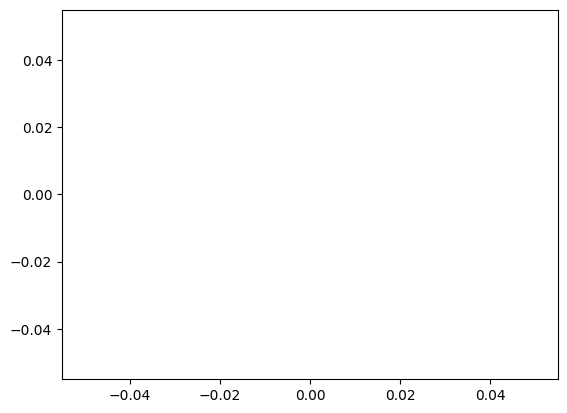

In [38]:
# from matplotlib import pyplot as plt
# tlnp = np.array(tl)
# tlnp = tlnp[200:]
# plt.plot(tlnp[1:] - tlnp[:-1])
# plt.show()

In [12]:
y_pred = (X_test @ w > 0) * 1.0


In [13]:
y_test_np = (y_test.detach().numpy() + 1.0)/2
y_pred_np = y_pred.detach().numpy()

In [14]:
from sklearn import metrics
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.5119942713927677
0.0
0.0


/Users/christopear/PycharmProjects/tarpoison/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


array([[1430,    0],
       [1363,    0]])

In [ ]:
# num_epochs = 100
# sb = tqdm(range(num_epochs))
# for epoch in sb:
#     loss = 0.5 * (w @ w) + hl(X_train @ w.T, y_train) ** 2
#     # L = max(0, 1 - y_train[inds[i]] * (torch.dot(w, torch.Tensor(X_train[inds[i]])) - b))**2
#     if L != 0: # if the loss is zero, Pytorch leaves the variables as a float 0.0, so we can't call backward() on it
#         L.backward()
#         w.data -= step_size * w.grad.data # step
#         b.data -= step_size * b.grad.data # step
#         w.grad.data.zero_()
#         b.grad.data.zero_()
#


In [ ]:
# inner = torch.Tensor(X_test[0]) - b
# print(inner.size())
# print(w.size())
#
# torch.dot(w, inner)

In [ ]:
# print('plane equation:  w=', w.detach().numpy(), 'b =', b.detach().numpy()[0])
#
# def accuracy(X, y):
#     correct = 0
#     for i in range(len(y)):
#         y_predicted = int(np.sign((torch.dot(w, torch.Tensor(X[i])) - b).detach().numpy()[0]))
#         if y_predicted == y[i]: correct += 1
#     return float(correct)/len(y)
#
# print('train accuracy', accuracy(X_train, y_train))
# print('test accuracy', accuracy(X_test, y_test))

In [ ]:
# def line_func(x, offset):
#     return   -1 * (offset - b.detach().numpy()[0] + w.detach().numpy()[0] * x ) / w.detach().numpy()[1]
#
# x = np.array([0,0.5,1])
# ym = line_func(x,  0)
# yp = line_func(x,  1)
# yn = line_func(x, -1)
#
# # x_index = 2
# # y_index = 3
# # plt.figure(figsize=(8, 6))
# # formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
# plt.colorbar(ticks=[0, 1], format=formatter)
# # plt.xlabel(iris.feature_names[x_index])
# # plt.ylabel(iris.feature_names[y_index])
# # plt.show()
# # plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
# # plt.colorbar(ticks=[0, 1, 2], format=formatter)
# # plt.xlabel(iris.feature_names[x_index])
# # plt.ylabel(iris.feature_names[y_index])
# plt.plot(x, ym)
# plt.plot(x, yp)
# plt.plot(x, yn)
# plt.show()